In [1]:
%matplotlib inline 
#%load_ext autoreload 
%reload_ext autoreload
%autoreload 2
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from __future__ import (division, 
                        print_function)

import os
import sys
import copy

import h5py
import numpy as np
import scipy
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel


import matplotlib as mpl
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 
mpl.rcParams.update({'xtick.color': 'k'})
mpl.rcParams.update({'ytick.color': 'k'})
mpl.rcParams.update({'font.size': 20})

import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)


import sys
sys.path.append('/Users/RAJ/github/kungpao')
from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap
import statsmodels.api as sm
from scipy.interpolate import interp1d 
from kungpao import io
from kungpao import utils
from kungpao import detection
from kungpao import imtools

import sep
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/pyraf/irafimport.py:116: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  retval = _originalImport(name, globals, locals, fromlist, level)


In [2]:
from astropy.modeling import models, fitting
import matplotlib.colors as colors
import matplotlib.cm as cmx
from pylab import figure, text, scatter, show
from math import factorial

In [3]:
def get_pixel_scale(file):
    f = h5py.File(file, 'r')
    map_size = f['config'].attrs['map_range_min']
    n_pixels = f['config'].attrs['map_npixel']
    pixel_scale=2 * (map_size/n_pixels)

    return pixel_scale

In [4]:
def get_ngalaxies(file):
    f = h5py.File(file, 'r')
    n_galaxies = len(f['catsh_id'])
    return n_galaxies

In [5]:
def merge_iso(iso_highres,iso_quick, merge_location):
    id_highres=find_nearest(iso_highres['sma_kpc'],merge_location)-1
    id_quick=find_nearest(iso_quick['sma_kpc'],merge_location)+1
    
    highres_half = iso_highres[:id_highres]
    quick_half = iso_quick[id_quick:]
    
    return vstack([highres_half,quick_half])

In [7]:
illustris_quick_file_hdf5='/Users/RAJ/summer_work_2018/notebook_tng/quick/galaxies_tng100_072_agez_lowres.hdf5'
illustris_highres_file_hdf5='/Users/RAJ/summer_work_2018/notebook_tng/high_res/galaxies_tng100_072_agez_highres.hdf5'
pixel_scale_highres, pixel_scale_quick = get_pixel_scale(illustris_highres_file_hdf5), get_pixel_scale(illustris_quick_file_hdf5)


In [8]:
illustris_highres_file = h5py.File(illustris_highres_file_hdf5, 'r')
illustris_quick_file = h5py.File(illustris_quick_file_hdf5, 'r')

In [9]:
high_res_direc = '/Users/RAJ/2019_paper/high_res/ellipse'
low_res_direc = '/Users/RAJ/2019_paper/low_res/ellipse'

In [10]:
illustris_0_ell_high = np.load(os.path.join(high_res_direc ,  'illustris_0_ell_high_oldv.npy'))
illustris_0_ell_quick = np.load(os.path.join(low_res_direc, 'illustris_0_ell_quick.npy'))

In [11]:
cat_sh_mstar=np.array(illustris_quick_file['catsh_SubhaloMassType'][:, 4])
logms_cat = np.log10(cat_sh_mstar)

In [12]:
pixel_scale_high = get_pixel_scale(illustris_highres_file_hdf5)
pixel_scale_quick = get_pixel_scale(illustris_quick_file_hdf5)

In [13]:
mask_bin1 = ((logms_cat >= 11.4) & (logms_cat < 11.5) )
mask_bin2 = ((logms_cat >= 11.5) & (logms_cat < 11.6)  )
mask_bin3 = ((logms_cat >= 11.6) & (logms_cat < 11.7)   )
mask_bin4 = ((logms_cat >= 11.7) & (logms_cat < 11.85) )
mask_bin5 = ((logms_cat >= 11.85) & (logms_cat < 12.4) )

In [15]:
quick_bin_1 = illustris_0_ell_quick[mask_bin1]
quick_bin_2 = illustris_0_ell_quick[mask_bin2]
quick_bin_3_ = illustris_0_ell_quick[mask_bin3]
quick_bin_4_ = illustris_0_ell_quick[mask_bin4]
quick_bin_5 = illustris_0_ell_quick[mask_bin5]

high_bin_1 = illustris_0_ell_high[mask_bin1]
high_bin_2 = illustris_0_ell_high[mask_bin2]
high_bin_3_ = illustris_0_ell_high[mask_bin3]
high_bin_4_ = illustris_0_ell_high[mask_bin4]
high_bin_5 = illustris_0_ell_high[mask_bin5]


In [16]:
del_ind_bin_3 = [5]
del_ind_bin_4 = [8]

In [17]:
quick_bin_3 = np.delete(quick_bin_3_,del_ind_bin_3)
quick_bin_4 = np.delete(quick_bin_4_,del_ind_bin_4)
high_bin_3 = np.delete(high_bin_3_,del_ind_bin_3)
high_bin_4 = np.delete(high_bin_4_,del_ind_bin_4)

In [18]:
def difference(high_res,quick,pixel_high,pixel_quick,kind,rmax,rmin,nbin):
    r = np.linspace(rmin,rmax,nbin)
    inter_quick = interp1d((quick[kind]['sma'] * pixel_quick ) , 
                                           ((quick[kind]['intens'] )/(pixel_quick ** 2)),
                                           bounds_error=False, 
                                           fill_value=np.nan, 
                                           kind='slinear')(r)
    inter_high = interp1d((high_res[kind]['sma'] * pixel_high ) , 
                                           ((high_res[kind]['intens'] )/(pixel_high ** 2)),
                                           bounds_error=False, 
                                           fill_value=np.nan, 
                                           kind='slinear')(r)
    rad_mask = (r >= 70.0) & (r <= 90.0)  #change the merging rad to 80 and plot the high and low res to see the radius with reliable results 
    
    diff = np.log10(inter_high[rad_mask]) - np.log10(inter_quick[rad_mask])
    
    mean_diff = np.nanmean(diff)
    
    if (mean_diff > 0 ):
        mean_in_norm = 10**mean_diff
        inter_quick_int = inter_quick + mean_in_norm
    else:
        abs_diff = np.abs(mean_diff)
        mean_in_norm = 10**abs_diff
        inter_quick_int = inter_quick - abs_diff
    mask_h = (r <= 80)
    mask_l = (r > 80)
    
    high_part = inter_high[mask_h]
    low_part =inter_quick_int[mask_l] 
        
        
    merged_prof = np.append(high_part,low_part)
    
    
    return merged_prof

In [19]:
def median_prof (high_res,quick,pixel_high,pixel_quick,kind,rmax,rmin,nbin):
    return np.nanmedian(np.stack(difference(gal_h,gal_q,pixel_high,pixel_quick,kind,rmax,rmin,nbin)for gal_h,gal_q in zip(high_res, quick)), axis=0 )

In [20]:
median_ins_bin_1 = median_prof(high_bin_1,quick_bin_1,pixel_scale_high,pixel_scale_quick,'ell_ins_3',600,0,700)
median_ins_bin_2 = median_prof(high_bin_2,quick_bin_2,pixel_scale_high,pixel_scale_quick,'ell_ins_3',600,0,700)
median_ins_bin_3 = median_prof(high_bin_3,quick_bin_3,pixel_scale_high,pixel_scale_quick,'ell_ins_3',600,0,700)
median_ins_bin_4 = median_prof(high_bin_4,quick_bin_4,pixel_scale_high,pixel_scale_quick,'ell_ins_3',600,0,700)
median_ins_bin_5 = median_prof(high_bin_5,quick_bin_5,pixel_scale_high,pixel_scale_quick,'ell_ins_3',600,0,700)

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app


In [21]:
median_exs_bin_1 = median_prof(high_bin_1,quick_bin_1,pixel_scale_high,pixel_scale_quick,'ell_exs_3',600,0,700)
median_exs_bin_2 = median_prof(high_bin_2,quick_bin_2,pixel_scale_high,pixel_scale_quick,'ell_exs_3',600,0,700)
median_exs_bin_3 = median_prof(high_bin_3,quick_bin_3,pixel_scale_high,pixel_scale_quick,'ell_exs_3',600,0,700)
median_exs_bin_4 = median_prof(high_bin_4,quick_bin_4,pixel_scale_high,pixel_scale_quick,'ell_exs_3',600,0,700)
median_exs_bin_5 = median_prof(high_bin_5,quick_bin_5,pixel_scale_high,pixel_scale_quick,'ell_exs_3',600,0,700)

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app


In [22]:
r = np.linspace(0,600,700)

In [23]:
def bootstrap(gal_array_high,gal_array_quick,pixel_h,pixel_q,kin,rmax,rmin,nbin,num_boot):
    tot_median = []
    size = len(gal_array_high)
    index_array = [i for i in range(size)]
    for j in range(num_boot):
        re_gal_array_high = gal_array_high[np.random.choice(index_array,size=size,replace=True)]
        re_gal_array_quick = gal_array_quick[np.random.choice(index_array,size=size,replace=True)]
        median = median_prof(re_gal_array_high,re_gal_array_quick,pixel_h,pixel_q,kin,rmax,rmin,nbin)
        tot_median.append(median)
    mean_median = np.nanmean(np.stack(tot_median[i] for i in range(num_boot)) , axis =0)
    err_median = np.nanstd(np.stack(tot_median[i] for i in range(num_boot)) , axis =0)
    return mean_median,err_median

In [24]:
boot_median_ins_bin_1,boot_err_ins_bin_1 = bootstrap(high_bin_1,quick_bin_1,pixel_scale_high,pixel_scale_quick,'ell_ins_3',600,0,700,500)
boot_median_ins_bin_2,boot_err_ins_bin_2 = bootstrap(high_bin_2,quick_bin_2,pixel_scale_high,pixel_scale_quick,'ell_ins_3',600,0,700,500)
boot_median_ins_bin_3,boot_err_ins_bin_3 = bootstrap(high_bin_3,quick_bin_3,pixel_scale_high,pixel_scale_quick,'ell_ins_3',600,0,700,500)
boot_median_ins_bin_4,boot_err_ins_bin_4 = bootstrap(high_bin_4,quick_bin_4,pixel_scale_high,pixel_scale_quick,'ell_ins_3',600,0,700,500)
boot_median_ins_bin_5,boot_err_ins_bin_5 = bootstrap(high_bin_5,quick_bin_5,pixel_scale_high,pixel_scale_quick,'ell_ins_3',600,0,700,500)

boot_median_exs_bin_1,boot_err_exs_bin_1 = bootstrap(high_bin_1,quick_bin_1,pixel_scale_high,pixel_scale_quick,'ell_exs_3',600,0,700,500)
boot_median_exs_bin_2,boot_err_exs_bin_2 = bootstrap(high_bin_2,quick_bin_2,pixel_scale_high,pixel_scale_quick,'ell_exs_3',600,0,700,500)
boot_median_exs_bin_3,boot_err_exs_bin_3 = bootstrap(high_bin_3,quick_bin_3,pixel_scale_high,pixel_scale_quick,'ell_exs_3',600,0,700,500)
boot_median_exs_bin_4,boot_err_exs_bin_4 = bootstrap(high_bin_4,quick_bin_4,pixel_scale_high,pixel_scale_quick,'ell_exs_3',600,0,700,500)
boot_median_exs_bin_5,boot_err_exs_bin_5 = bootstrap(high_bin_5,quick_bin_5,pixel_scale_high,pixel_scale_quick,'ell_exs_3',600,0,700,500)


/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app


In [61]:
mask_ = ((np.log10(r) >= 0.72) & (np.log10(r) <= 2.5))

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [70]:
def sersic_fit(median_profile,weights_array):
    mask_ = ((np.log10(r) >= 0.72) & (np.log10(r) <= 2.5))
    gal_sma = np.asarray(r[mask_])
    gal_intens = np.asarray(median_profile)
    const_norm = np.nanmax(np.asarray(median_profile))
    gal_intens_norm = np.asarray(median_profile[mask_]) / const_norm
    sersic_mod = models.Sersic1D(amplitude=1., r_eff=2, n=3)
    
    sersic_prof = sersic_mod(r)
    sersic_fit = fitting.LevMarLSQFitter()
    uncern = (weights_array[mask_])**(-1)
    sersic_best = sersic_fit(sersic_mod, gal_sma, gal_intens_norm,maxiter=500, weights = uncern)
    sers_int = sersic_best(r) * const_norm
    #residual = np.log10(sersic_best(r)) - np.log10(np.asarray(median_profile) )
    residual = np.log10(sersic_best(r) - np.asarray(median_profile))
    amp,r_eff,n_ind = (sersic_best.parameters)
    r_eff_str  = str(r_eff)
    n_ind_str = str(n_ind)
    d_label = 'amp =%5.3f r_eff=%5.3f n=%1.3f ' % (amp,r_eff,n_ind)

    
    return sers_int,amp,r_eff,n_ind,residual

In [71]:
sers_exs_bin1,amp_exs_bin_1,r_eff_exs_bin_1,n_ind_exs_bin_1,residual_exs_bin1 = sersic_fit(boot_median_exs_bin_1,boot_err_exs_bin_1)
sers_exs_bin2,amp_exs_bin_2,r_eff_exs_bin_2,n_ind_exs_bin_2,residual_exs_bin2 = sersic_fit(boot_median_exs_bin_2,boot_err_exs_bin_2)
sers_exs_bin3,amp_exs_bin_3,r_eff_exs_bin_3,n_ind_exs_bin_3,residual_exs_bin3 = sersic_fit(boot_median_exs_bin_3,boot_err_exs_bin_3)
sers_exs_bin4,amp_exs_bin_4,r_eff_exs_bin_4,n_ind_exs_bin_4,residual_exs_bin4 = sersic_fit(boot_median_exs_bin_4,boot_err_exs_bin_4)
sers_exs_bin5,amp_exs_bin_5,r_eff_exs_bin_5,n_ind_exs_bin_5,residual_exs_bin5 = sersic_fit(boot_median_exs_bin_5,boot_err_exs_bin_5)

sers_ins_bin1,amp_ins_bin_1,r_eff_ins_bin_1,n_ind_ins_bin_1,residual_ins_bin1 = sersic_fit(boot_median_ins_bin_1,boot_err_ins_bin_1)
sers_ins_bin2,amp_ins_bin_2,r_eff_ins_bin_2,n_ind_ins_bin_2,residual_ins_bin2 = sersic_fit(boot_median_ins_bin_2,boot_err_ins_bin_2)
sers_ins_bin3,amp_ins_bin_3,r_eff_ins_bin_3,n_ind_ins_bin_3,residual_ins_bin3 = sersic_fit(boot_median_ins_bin_3,boot_err_ins_bin_3)
sers_ins_bin4,amp_ins_bin_4,r_eff_ins_bin_4,n_ind_ins_bin_4,residual_ins_bin4 = sersic_fit(boot_median_ins_bin_4,boot_err_ins_bin_4)
sers_ins_bin5,amp_ins_bin_5,r_eff_ins_bin_5,n_ind_ins_bin_5,residual_ins_bin5 = sersic_fit(boot_median_ins_bin_5,boot_err_ins_bin_5)

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [40]:
label_exs_1[]

'p'

In [46]:
def savitzkyGolay(x_in, y_in, use_log = False, deriv = 0, window_size = 19, order = 4):

    if use_log and deriv > 1:
        print("WARNING: higher derivatives of logged data are not the same as taking log-derivatives.")

    if use_log:
        if np.min(y_in) < 0:
            print(y_in)
            raise ValueError("Negative values in array to be logged.")
        x = np.log10(x_in)
        y = np.log10(y_in)
    else:
        x = x_in
        y = y_in

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError as dummymsg:
        raise ValueError("savitzkyGolay: Window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("savitzkyGolay: Window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("savitzkyGolay: Window_size is too small for the polynomials order")

    rate = (len(x) - 1.0) / (x[-1] - x[0])
    order_range = list(range(order + 1))
    half_window = (window_size - 1) // 2

    # Precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window + 1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    
    # Pad the signal at the extremes with values taken from the signal itself
    firstvals = y[0] - np.abs(y[1:half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    
    # Convolve the signal with the coefficients
    ret = np.convolve(m[::-1], y, mode = 'valid')

    if use_log and deriv == 0:
        ret = 10**ret

    return ret

In [64]:
slope_ins_bin1 = savitzkyGolay(x_in=r,y_in= boot_median_ins_bin_1,use_log = True, deriv = 1, window_size = 59, order = 2)
slope_ins_bin2 = savitzkyGolay(r,(boot_median_ins_bin_2),use_log = True, deriv = 1, window_size = 39, order = 4)
slope_ins_bin3 = savitzkyGolay((r),(boot_median_ins_bin_3),use_log = True, deriv = 1, window_size = 39, order = 4)
slope_ins_bin4 = savitzkyGolay((r),(boot_median_ins_bin_4),use_log = True, deriv = 1, window_size = 39, order = 4)
slope_ins_bin5 = savitzkyGolay((r),(boot_median_ins_bin_5),use_log = True, deriv = 1, window_size = 39, order = 4)

slope_exs_bin1 = savitzkyGolay((r),(boot_median_exs_bin_1),use_log = True, deriv = 1, window_size = 39, order = 4)
slope_exs_bin2 = savitzkyGolay((r),(boot_median_exs_bin_2),use_log = True, deriv = 1, window_size = 39, order = 4)
slope_exs_bin3 = savitzkyGolay((r),(boot_median_exs_bin_3),use_log = True, deriv = 1, window_size = 39, order = 4)
slope_exs_bin4 = savitzkyGolay((r),(boot_median_exs_bin_4),use_log = True, deriv = 1, window_size = 39, order = 4)
slope_exs_bin5 = savitzkyGolay((r),(boot_median_exs_bin_5),use_log = True, deriv = 1, window_size = 39, order = 4)

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


In [65]:
def plotting2(median_prof_array,radius_array,ax,xlim_min,xlim_max,ylim_min,ylim_max,lim_val=0):
    labels = ['$11.4 \leq log(M)<11.5$','$11.5 \leq log(M)<11.6$','$11.6 \leq log(M)<11.7$','$11.7 \leq log(M)<11.85$','$11.85 \leq log(M)<12.4$']
    plt.figure(figsize=(20,8))
    for i in range(len(median_prof_array)-lim_val):
        colorVal = scalarMap.to_rgba(values[i])
        
        ax.plot(np.log10(radius_array),np.log10(median_prof_array[i]),c=colorVal,linestyle ='--')
        
        ax.set_xlim(xlim_min,xlim_max)
        ax.set_ylim(ylim_min,ylim_max)
      

In [72]:
sers_ins_array = np.array([sers_ins_bin1,sers_ins_bin2,sers_ins_bin3,sers_ins_bin4,sers_ins_bin5])
residual_array_ins = np.array([residual_ins_bin1,residual_ins_bin2,residual_ins_bin3,residual_ins_bin4,residual_ins_bin5])
residual_array_exs = np.array([residual_exs_bin1,residual_exs_bin2,residual_exs_bin3,residual_exs_bin4,residual_exs_bin5])

sers_exs_array = np.array([sers_exs_bin1,sers_exs_bin2,sers_exs_bin3,sers_exs_bin4,sers_exs_bin5])

In [73]:
def plotting_3(res_array,radius_array,ax,xlim_min,xlim_max,ylim_min,ylim_max,lim_val=0):
   
    plt.figure(figsize=(25,25))
    for i in range(len(res_array)-lim_val):
        colorVal = scalarMap.to_rgba(values[i])
        
        ax.plot(np.log10(radius_array),res_array[i],c=colorVal,label='bin'+str(i+1))
        
        ax.set_xlim(xlim_min,xlim_max)
        ax.set_ylim(ylim_min,ylim_max)

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:51: Ru

[]

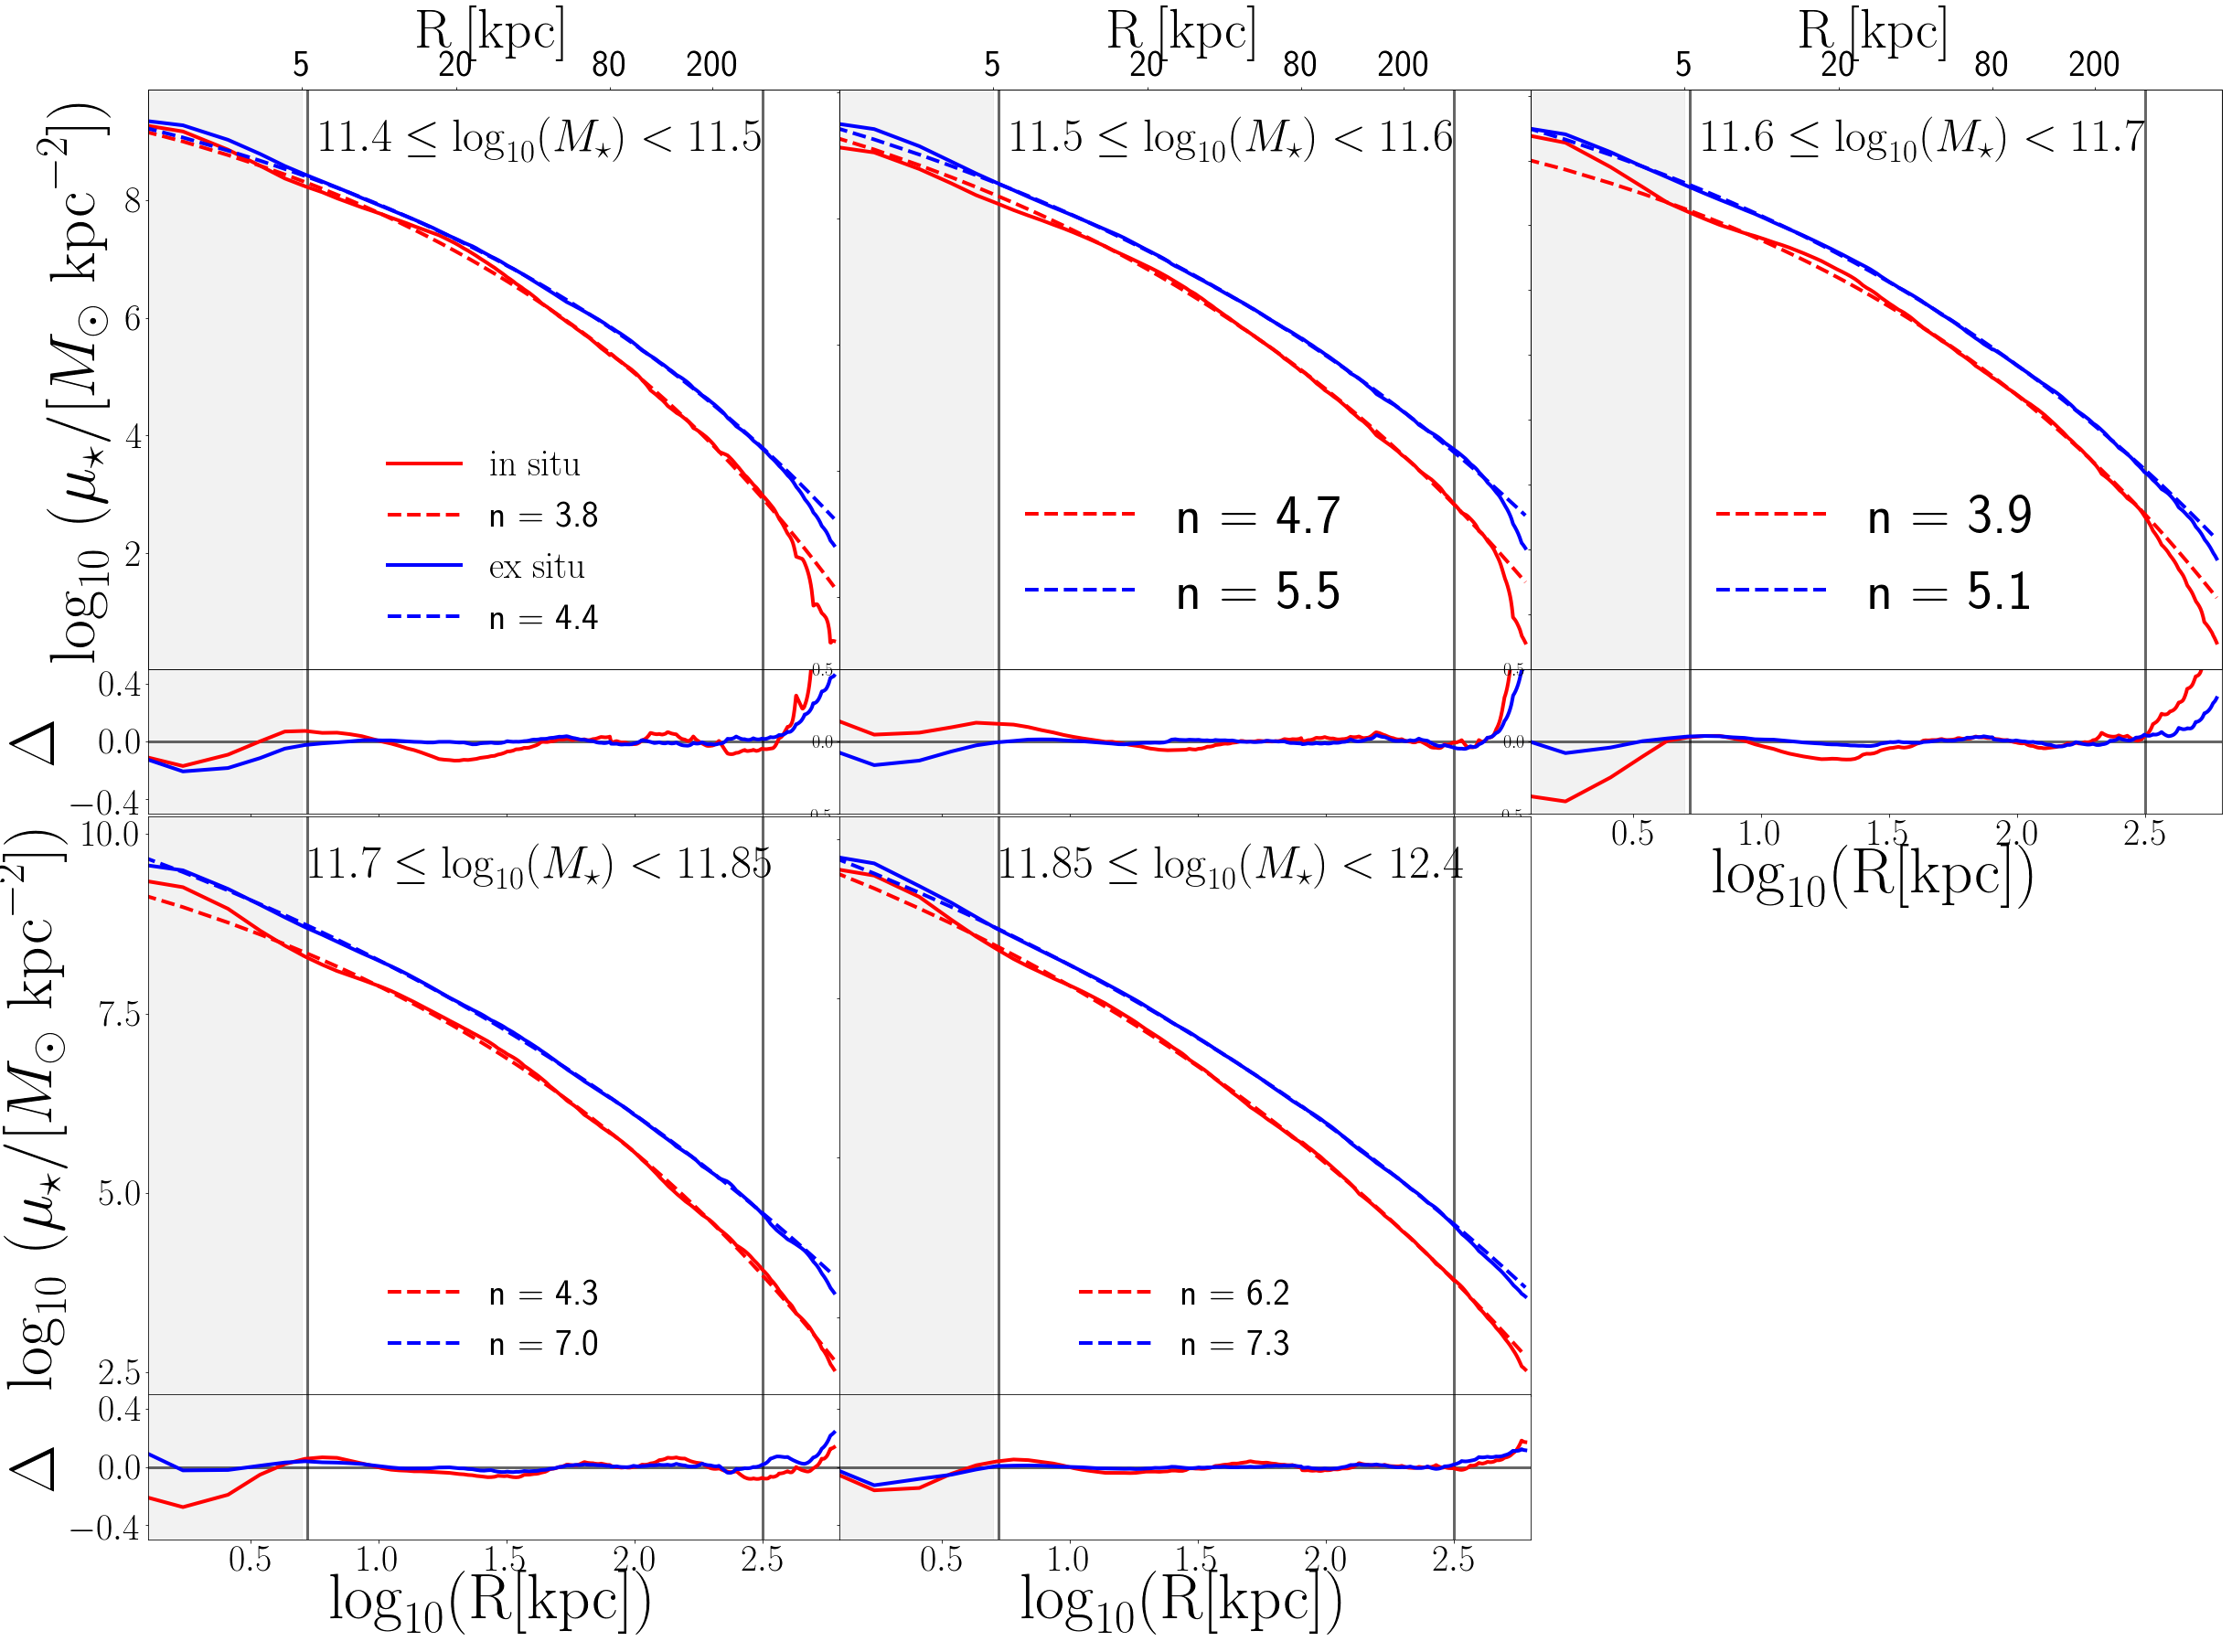

In [130]:
fig = plt.figure(figsize=(35, 22))
ax1 = plt.axes([0.1,0.75,0.3,0.4])
ax11 = plt.axes([0.1,0.65,0.3,0.1])
ax2 = plt.axes([0.4,0.75,0.3,0.4])
ax22 = plt.axes([0.4,0.65,0.3,0.1])
ax3 = plt.axes([0.7,0.75,0.3,0.4])
ax33 = plt.axes([0.7,0.65,0.3,0.1])
ax4 = plt.axes([0.1,0.248,0.3,0.4])
ax44 = plt.axes([0.1,0.149,0.3,0.1])
ax5 = plt.axes([0.4,0.248,0.3,0.4])
ax55 = plt.axes([0.4,0.149,0.3,0.1])


ax1.axvline(0.72 ,  linewidth=3.0, alpha=0.6,color = 'black')
ax11.axvline(0.72 , linewidth=3.0, alpha=0.6,color = 'black')
ax1.axvline(2.5 ,  linewidth=3.0, alpha=0.6,color = 'black')
ax11.axvline(2.5 , linewidth=3.0, alpha=0.6,color = 'black')
ax1.plot(np.log10(r),np.log10(boot_median_ins_bin_1),color='r',linewidth = 4.0,label = r'\rm in situ')
ax1.plot(np.log10(r),np.log10(sers_ins_bin1),color='r',linestyle = '--',linewidth = 4.0,label = 'n = %1.1f ' % (n_ind_ins_bin_1))
#ax1.plot(np.log10(r[mask_]),np.log10(sers_ins_bin1[mask_]),color='darkorange',linestyle = '--',linewidth = 4.0,label = 'n = 6.599')
ax1.plot(np.log10(r),np.log10(boot_median_exs_bin_1),color='blue',linewidth = 4.0,label = r'\rm ex situ')
ax1.plot(np.log10(r),np.log10(sers_exs_bin1),color='blue',linestyle = '--',linewidth = 4.0,label = 'n = %1.1f ' % (n_ind_exs_bin_1))
ax11.axhline(0.0 , color ='black', linewidth=3.0, alpha=0.6)
ax11.plot(np.log10(r),np.log10(sers_ins_bin1)-np.log10(boot_median_ins_bin_1),color='r',linewidth = 4.0)
ax11.plot(np.log10(r),np.log10(sers_exs_bin1)-np.log10(boot_median_exs_bin_1),color='blue',linewidth = 4.0)
ax1.set_xlim(0.1,2.8)
ax11.set_xlim(0.1,2.8)
ax11.set_ylim(-0.5,0.5)
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([ np.log10(5),np.log10(20), np.log10(80), np.log10(200)])
ax1_twin.xaxis.set_ticklabels([5, 20, 80, 200])
ax1_twin.tick_params(axis='both', which='major',  labelsize=40)
ax1_twin.set_xlabel(r'$\rm R \: [\rm kpc]$', fontsize=60)
ax1.axvspan(0, np.log10(5), alpha=0.1, color='gray')
ax11.axvspan(0, np.log10(5), alpha=0.1, color='gray')
ax1.legend(fontsize =40,frameon=False)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.tick_params(axis='y', which='major', labelsize=40)
ax11.yaxis.set_major_locator(plt.MaxNLocator(3))
ax11.tick_params(axis='y', which='major', labelsize=40)
ax1.set_ylabel(r'$\log_{10 }\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',fontsize = 70)
ax11.set_ylabel(r'$\Delta$',fontsize = 70)

ax2.axvline(0.72 ,  linewidth=3.0, alpha=0.6,color = 'black')
ax22.axvline(0.72 , linewidth=3.0, alpha=0.6,color = 'black')
ax2.axvline(2.5 ,  linewidth=3.0, alpha=0.6,color = 'black')
ax22.axvline(2.5 , linewidth=3.0, alpha=0.6,color = 'black')
ax2.plot(np.log10(r),np.log10(boot_median_ins_bin_2),color='r',linewidth = 4.0)
ax2.plot(np.log10(r),np.log10(sers_ins_bin2),color='r',linestyle = '--',linewidth = 4.0,label = 'n = %1.1f ' % (n_ind_ins_bin_2))
#ax1.plot(np.log10(r[mask_]),np.log10(sers_ins_bin1[mask_]),color='darkorange',linestyle = '--',linewidth = 4.0,label = 'n = 6.599')
ax2.plot(np.log10(r),np.log10(boot_median_exs_bin_2),color='blue',linewidth = 4.0)
ax2.plot(np.log10(r),np.log10(sers_exs_bin2),color='blue',linestyle = '--',linewidth = 4.0,label = 'n = %1.1f ' % (n_ind_exs_bin_2))
ax22.axhline(0.0 , color ='black', linewidth=3.0, alpha=0.6)
ax22.plot(np.log10(r),np.log10(sers_ins_bin2)-np.log10(boot_median_ins_bin_2),color='r',linewidth = 4.0)
ax22.plot(np.log10(r),np.log10(sers_exs_bin2)-np.log10(boot_median_exs_bin_2),color='blue',linewidth = 4.0)
ax2.set_xlim(0.1,2.8)
ax22.set_xlim(0.1,2.8)
ax22.set_ylim(-0.5,0.5)
x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([ np.log10(5),np.log10(20), np.log10(80), np.log10(200)])
ax2_twin.xaxis.set_ticklabels([5, 20, 80, 200])
ax2_twin.tick_params(axis='both', which='major',  labelsize=40)
ax2_twin.set_xlabel(r'$\rm R \: [\rm kpc]$', fontsize=60)
ax2.axvspan(0, np.log10(5), alpha=0.1, color='gray')
ax22.axvspan(0, np.log10(5), alpha=0.1, color='gray')
ax2.legend(fontsize =60,frameon=False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
text(0.57, 0.90,'$11.5 \leq \log_{10 }(M_{\star})<11.6$',fontsize =50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax2.transAxes)
text(0.57, 0.90,'$11.4 \leq \log_{10 }(M_{\star})<11.5$',fontsize =50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax1.transAxes)


ax3.axvline(0.72 ,  linewidth=3.0, alpha=0.6,color = 'black')
ax33.axvline(0.72 , linewidth=3.0, alpha=0.6,color = 'black')
ax3.axvline(2.5 ,  linewidth=3.0, alpha=0.6,color = 'black')
ax33.axvline(2.5 , linewidth=3.0, alpha=0.6,color = 'black')
ax3.plot(np.log10(r),np.log10(boot_median_ins_bin_3),color='r',linewidth = 4.0)
ax3.plot(np.log10(r),np.log10(sers_ins_bin3),color='r',linestyle = '--',linewidth = 4.0,label = 'n = %1.1f ' % (n_ind_ins_bin_3))
#ax1.plot(np.log10(r[mask_]),np.log10(sers_ins_bin1[mask_]),color='darkorange',linestyle = '--',linewidth = 4.0,label = 'n = 6.599')
ax3.plot(np.log10(r),np.log10(boot_median_exs_bin_3),color='blue',linewidth = 4.0)
ax3.plot(np.log10(r),np.log10(sers_exs_bin3),color='blue',linestyle = '--',linewidth = 4.0,label = 'n = %1.1f ' % (n_ind_exs_bin_3))
ax33.axhline(0.0 , color ='black', linewidth=3.0, alpha=0.6)
ax33.plot(np.log10(r),np.log10(sers_ins_bin3)-np.log10(boot_median_ins_bin_3),color='r',linewidth = 4.0)
ax33.plot(np.log10(r),np.log10(sers_exs_bin3)-np.log10(boot_median_exs_bin_3),color='blue',linewidth = 4.0)
ax3.set_xlim(0.1,2.8)
ax33.set_xlim(0.1,2.8)
ax33.set_ylim(-0.5,0.5)
x1, x2 = ax3.get_xlim()
ax3_twin = ax3.twiny()
ax3_twin.set_xlim(x1, x2)
ax3_twin.figure.canvas.draw()
ax3_twin.xaxis.set_ticks([ np.log10(5),np.log10(20), np.log10(80), np.log10(200)])
ax3_twin.xaxis.set_ticklabels([5, 20, 80, 200])
ax3_twin.tick_params(axis='both', which='major',  labelsize=40)
ax3_twin.set_xlabel(r'$\rm R \: [\rm kpc]$', fontsize=60)
ax3.axvspan(0, np.log10(5), alpha=0.1, color='gray')
ax33.axvspan(0, np.log10(5), alpha=0.1, color='gray')
ax3.legend(fontsize =60,frameon=False)
ax33.set_xlabel(r'$\log_{10 } (\rm R[\rm kpc]) $',fontsize = 70)
ax3.set_yticklabels([])
text(0.57, 0.90,'$11.6 \leq \log_{10 }(M_{\star})<11.7$',fontsize =50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax3.transAxes)
ax33.tick_params(axis='x', which='major', labelsize=40)


ax4.axvline(0.72 ,  linewidth=3.0, alpha=0.6,color = 'black')
ax44.axvline(0.72 , linewidth=3.0, alpha=0.6,color = 'black')
ax4.axvline(2.5 ,  linewidth=3.0, alpha=0.6,color = 'black')
ax44.axvline(2.5 , linewidth=3.0, alpha=0.6,color = 'black')
ax4.plot(np.log10(r),np.log10(boot_median_ins_bin_4),color='r',linewidth = 4.0)
ax4.plot(np.log10(r),np.log10(sers_ins_bin4),color='r',linestyle = '--',linewidth = 4.0,label = 'n = %1.1f ' % (n_ind_ins_bin_4))
#ax1.plot(np.log10(r[mask_]),np.log10(sers_ins_bin1[mask_]),color='darkorange',linestyle = '--',linewidth = 4.0,label = 'n = 6.599')
ax4.plot(np.log10(r),np.log10(boot_median_exs_bin_4),color='blue',linewidth = 4.0)
ax4.plot(np.log10(r),np.log10(sers_exs_bin4),color='blue',linestyle = '--',linewidth = 4.0,label = 'n = %1.1f ' % (n_ind_exs_bin_4))
ax44.axhline(0.0 , color ='black', linewidth=3.0, alpha=0.6)
ax44.plot(np.log10(r),np.log10(sers_ins_bin4)-np.log10(boot_median_ins_bin_4),color='r',linewidth = 4.0)
ax44.plot(np.log10(r),np.log10(sers_exs_bin4)-np.log10(boot_median_exs_bin_4),color='blue',linewidth = 4.0)
ax4.set_xlim(0.1,2.8)
ax44.set_xlim(0.1,2.8)
ax44.set_ylim(-0.5,0.5)
ax4.axvspan(0, np.log10(5), alpha=0.1, color='gray')
ax44.axvspan(0, np.log10(5), alpha=0.1, color='gray')
ax4.legend(fontsize =40,frameon=False)
ax4.yaxis.set_major_locator(plt.MaxNLocator(4))
ax4.tick_params(axis='y', which='major', labelsize=40)
ax44.yaxis.set_major_locator(plt.MaxNLocator(3))
ax44.tick_params(axis='y', which='major', labelsize=40)
ax4.set_ylabel(r'$\log_{10 }\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',fontsize = 70)
ax44.set_ylabel(r'$\Delta$',fontsize = 70)

ax44.set_xlabel(r'$\log_{10 } (\rm R[\rm kpc]) $',fontsize = 70)
text(0.57, 0.90,'$11.7 \leq \log_{10 }(M_{\star})<11.85$',fontsize =50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax4.transAxes)
ax44.tick_params(axis='x', which='major', labelsize=40)


ax5.axvline(0.72 ,  linewidth=3.0, alpha=0.6,color = 'black')
ax55.axvline(0.72 , linewidth=3.0, alpha=0.6,color = 'black')
ax5.axvline(2.5 ,  linewidth=3.0, alpha=0.6,color = 'black')
ax55.axvline(2.5 , linewidth=3.0, alpha=0.6,color = 'black')
ax5.plot(np.log10(r),np.log10(boot_median_ins_bin_5),color='r',linewidth = 4.0)
ax5.plot(np.log10(r),np.log10(sers_ins_bin5),color='r',linestyle = '--',linewidth = 4.0,label = 'n = %1.1f ' % (n_ind_ins_bin_5))
#ax1.plot(np.log10(r[mask_]),np.log10(sers_ins_bin1[mask_]),color='darkorange',linestyle = '--',linewidth = 4.0,label = 'n = 6.599')
ax5.plot(np.log10(r),np.log10(boot_median_exs_bin_5),color='blue',linewidth = 4.0)
ax5.plot(np.log10(r),np.log10(sers_exs_bin5),color='blue',linestyle = '--',linewidth = 4.0,label = 'n = %1.1f ' % (n_ind_exs_bin_5))
ax55.axhline(0.0 , color ='black', linewidth=3.0, alpha=0.6)
ax55.plot(np.log10(r),np.log10(sers_ins_bin5)-np.log10(boot_median_ins_bin_5),color='r',linewidth = 4.0)
ax55.plot(np.log10(r),np.log10(sers_exs_bin5)-np.log10(boot_median_exs_bin_5),color='blue',linewidth = 4.0)
ax5.set_xlim(0.1,2.8)
ax55.set_xlim(0.1,2.8)
ax55.set_ylim(-0.5,0.5)
ax5.axvspan(0, np.log10(5), alpha=0.1, color='gray')
ax55.axvspan(0, np.log10(5), alpha=0.1, color='gray')
ax5.legend(fontsize =40,frameon=False)
ax5.yaxis.set_major_locator(plt.MaxNLocator(4))
ax5.tick_params(axis='y', which='major', labelsize=40)
ax55.yaxis.set_major_locator(plt.MaxNLocator(3))
ax55.tick_params(axis='y', which='major', labelsize=40)
#ax4.set_ylabel(r'$\log_{10 }\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',fontsize = 70)
#ax44.set_ylabel(r'$\Delta$',fontsize = 70)

ax55.set_xlabel(r'$\log_{10 } (\rm R[\rm kpc]) $',fontsize = 70)
text(0.57, 0.90,'$11.85 \leq \log_{10 }(M_{\star})<12.4$',fontsize =50,
     horizontalalignment='center',
     verticalalignment='center',transform=ax5.transAxes)
ax55.tick_params(axis='x', which='major', labelsize=40)
ax5.set_yticklabels([])
ax55.set_yticklabels([])







